In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from wordcloud import WordCloud, STOPWORDS

df = pd.read_csv('C:\\Users\\Divya\\Downloads\\customer_support_tickets.csv') 
df.columns = df.columns.str.strip()
df.head()


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [2]:
print(df.shape)
df.info()
print("\nMissing values per column:\n")
print(df.isnull().sum())


(8469, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   objec

In [3]:
df_eda = df.copy()  
df_model = df.copy()
df_model = df_model.dropna(subset=['Customer Satisfaction Rating']).reset_index(drop=True)

print("EDA rows:", df_eda.shape)
print("Modeling rows (target present):", df_model.shape)


EDA rows: (8469, 17)
Modeling rows (target present): (2769, 17)


In [7]:
df_eda['Date of Purchase'] = pd.to_datetime(df_eda['Date of Purchase'], errors='coerce')
df_model['Date of Purchase'] = pd.to_datetime(df_model['Date of Purchase'], errors='coerce')

def to_timedelta_hours(x):   
    try:
        td = pd.to_timedelta(x)
        return td.total_seconds() / 3600.0
    except Exception:
        if pd.isna(x): 
            return np.nan
        s = str(x)       
        import re
        m = re.search(r'(\d+)\s*day', s)
        if m:
            return float(m.group(1)) * 24.0
        m = re.search(r'(\d+)\s*hour', s)
        if m:
            return float(m.group(1))
        m = re.search(r'(\d+):(\d+):(\d+)', s)
        if m:
            h = float(m.group(1)) + float(m.group(2))/60 + float(m.group(3))/3600
            return h
    
        m = re.search(r'(\d+(\.\d+)?)', s)
        if m:
            return float(m.group(1))
        return np.nan

df_eda['FirstResponseHours'] = df_eda['First Response Time'].apply(to_timedelta_hours)
df_eda['ResolutionHours'] = df_eda['Time to Resolution'].apply(to_timedelta_hours)

df_model['FirstResponseHours'] = df_model['First Response Time'].apply(to_timedelta_hours)
df_model['ResolutionHours'] = df_model['Time to Resolution'].apply(to_timedelta_hours)


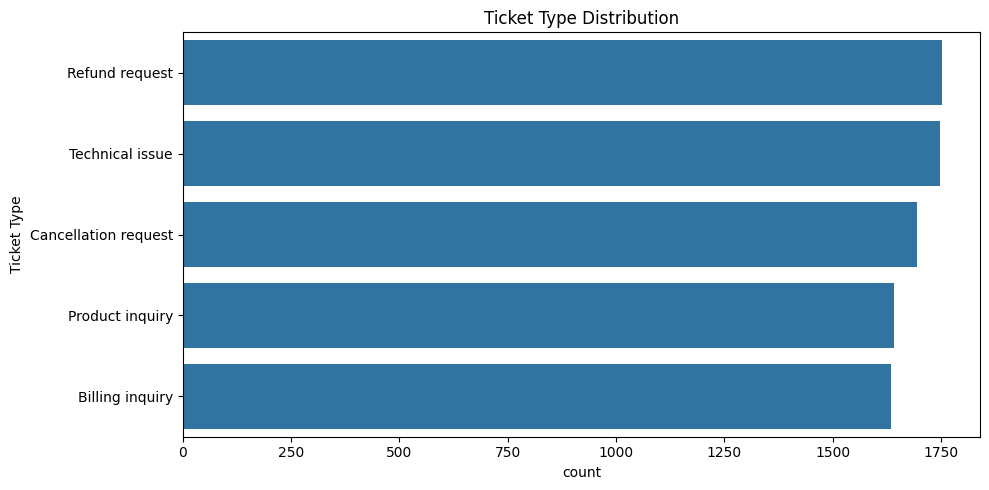

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_eda, y='Ticket Type', order=df_eda['Ticket Type'].value_counts().index)
plt.title('Ticket Type Distribution')
plt.tight_layout()
plt.savefig('ticket_type_distribution.png', dpi=200)
plt.show()



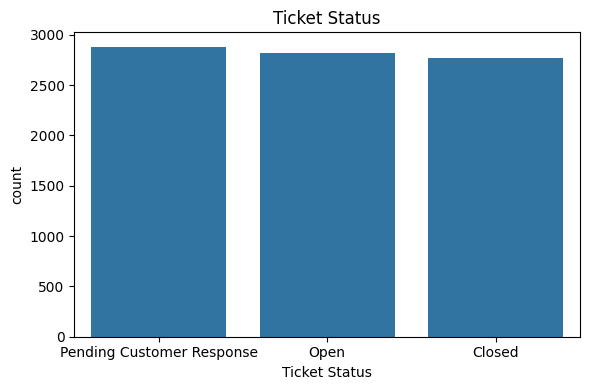

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_eda, x='Ticket Status', order=df_eda['Ticket Status'].value_counts().index)
plt.title('Ticket Status')
plt.tight_layout()
plt.savefig('ticket_status.png', dpi=200)
plt.show()


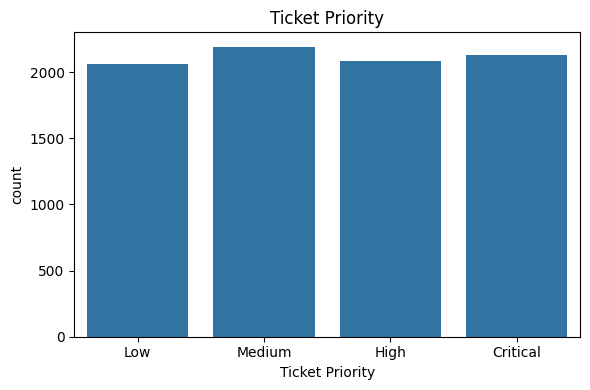

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_eda, x='Ticket Priority', order=['Low','Medium','High','Critical'])
plt.title('Ticket Priority')
plt.tight_layout()
plt.savefig('ticket_priority.png', dpi=200)
plt.show()


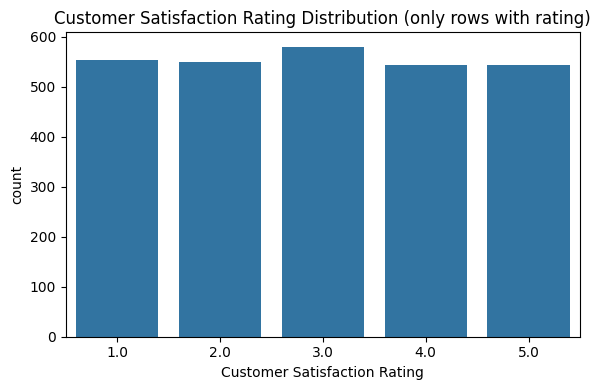

In [19]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_model, x='Customer Satisfaction Rating', order=sorted(df_model['Customer Satisfaction Rating'].unique()))
plt.title('Customer Satisfaction Rating Distribution (only rows with rating)')
plt.tight_layout()
plt.savefig('satisfaction_dist.png', dpi=200)
plt.show()


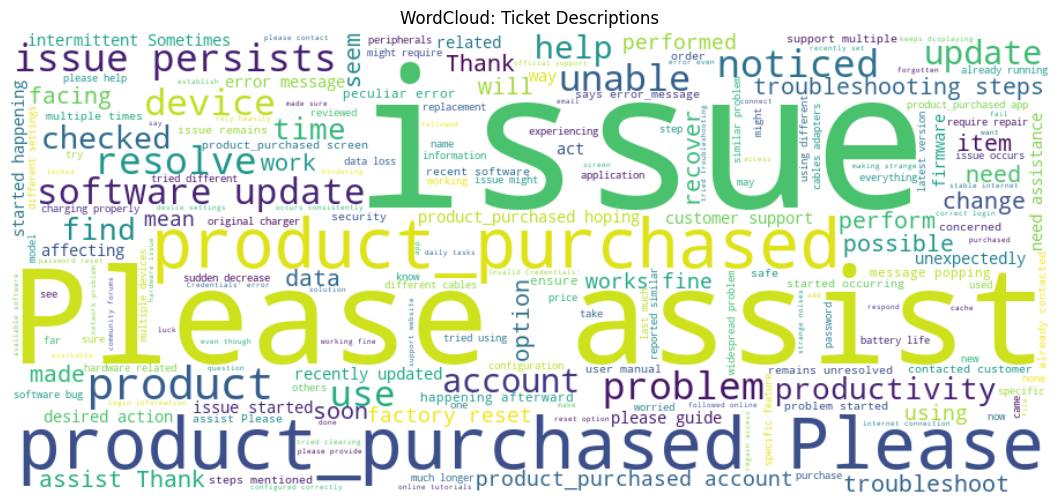

In [22]:
text = df_eda['Ticket Description'].dropna().astype(str).str.cat(sep=' ')
wordcloud = WordCloud(width=900, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

plt.figure(figsize=(14,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud: Ticket Descriptions')
plt.savefig('wordcloud_ticket_desc.png', dpi=200)
plt.show()


Ticket Priority
Critical    2.958678
Medium      2.976945
High        2.982979
Low         3.052795
Name: Customer Satisfaction Rating, dtype: float64


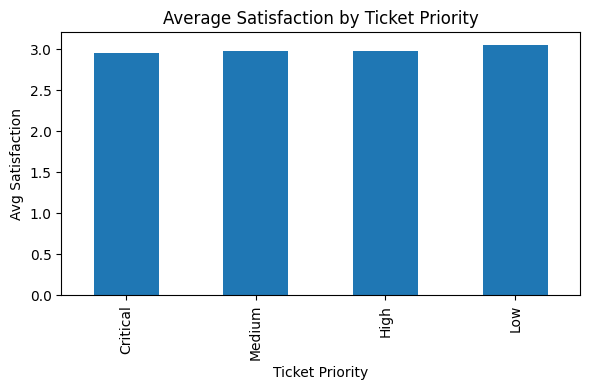

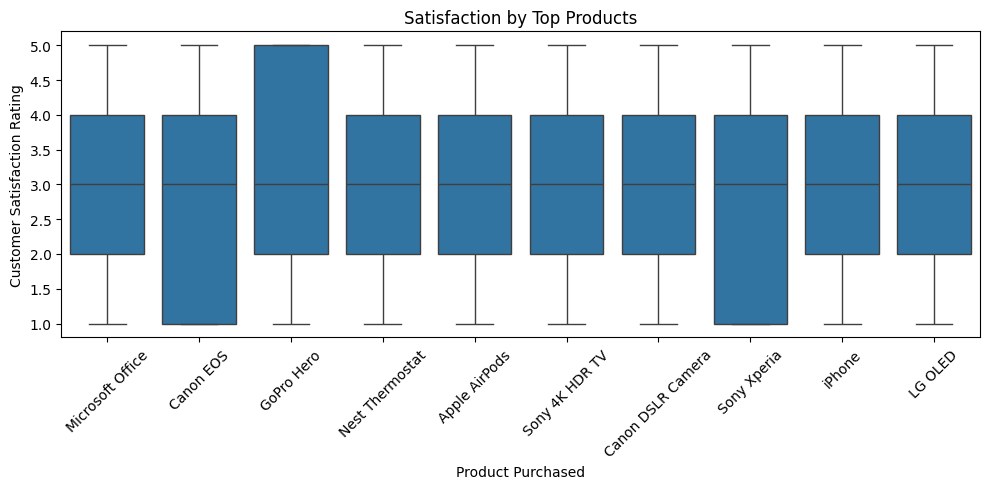

In [31]:
by_priority = df_model.groupby('Ticket Priority')['Customer Satisfaction Rating'].mean().sort_values()
print(by_priority)

plt.figure(figsize=(6,4))
by_priority.plot(kind='bar')
plt.ylabel('Avg Satisfaction')
plt.title('Average Satisfaction by Ticket Priority')
plt.tight_layout()
plt.savefig('avg_satisfaction_by_priority.png', dpi=200)
plt.show()

#Product Purchased (top 10)
top_products = df_model['Product Purchased'].value_counts().nlargest(10).index
plt.figure(figsize=(10,5))
sns.boxplot(data=df_model[df_model['Product Purchased'].isin(top_products)], x='Product Purchased', y='Customer Satisfaction Rating')
plt.xticks(rotation=45)
plt.title('Satisfaction by Top Products')
plt.tight_layout()
plt.savefig('satisfaction_by_product.png', dpi=200)
plt.show()


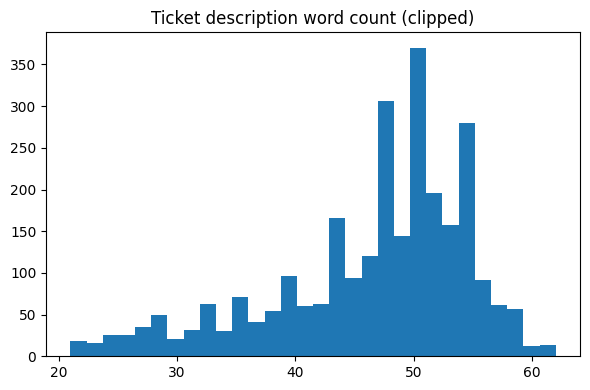

In [34]:
df_model['desc_len'] = df_model['Ticket Description'].astype(str).apply(len)
df_model['desc_wordcount'] = df_model['Ticket Description'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
plt.hist(df_model['desc_wordcount'].clip(upper=200), bins=30)
plt.title('Ticket description word count (clipped)')
plt.tight_layout()
plt.savefig('desc_wordcount.png', dpi=200)
plt.show()


In [36]:
df_model['Satisfied'] = (df_model['Customer Satisfaction Rating'] >= 4).astype(int)
df_model['Satisfied'].value_counts() 


Satisfied
0    1682
1    1087
Name: count, dtype: int64

In [45]:
features = ['Customer Age','FirstResponseHours','ResolutionHours','desc_len','desc_wordcount',
            'Customer Gender','Product Purchased','Ticket Type','Ticket Priority','Ticket Channel']

model_df = df_model[features + ['Satisfied']].copy()
model_df['FirstResponseHours'] = model_df['FirstResponseHours'].fillna(model_df['FirstResponseHours'].median())
model_df['ResolutionHours'] = model_df['ResolutionHours'].fillna(model_df['ResolutionHours'].median())
model_df['desc_len'] = model_df['desc_len'].fillna(0)
model_df['desc_wordcount'] = model_df['desc_wordcount'].fillna(0)
model_df['Customer Age'] = model_df['Customer Age'].fillna(model_df['Customer Age'].median())

for c in ['Customer Gender','Product Purchased','Ticket Type','Ticket Priority','Ticket Channel']:
    model_df[c] = model_df[c].fillna('Unknown')

model_df.shape


(2769, 11)

In [49]:
X = model_df.drop('Satisfied', axis=1)
y = model_df['Satisfied']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (2215, 10) Test: (554, 10)


In [54]:
num_features = ['Customer Age','FirstResponseHours','ResolutionHours','desc_len','desc_wordcount']
cat_features = ['Customer Gender','Product Purchased','Ticket Type','Ticket Priority','Ticket Channel']

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

clf = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

clf.fit(X_train, y_train)


,steps,"[('pre', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Accuracy: 0.5956678700361011

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.89      0.73       337
           1       0.45      0.13      0.21       217

    accuracy                           0.60       554
   macro avg       0.53      0.51      0.47       554
weighted avg       0.55      0.60      0.52       554



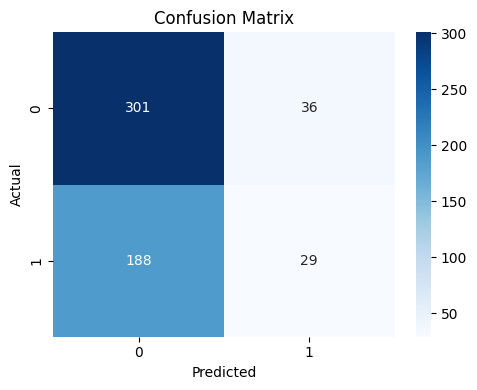

In [57]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=200)
plt.show()


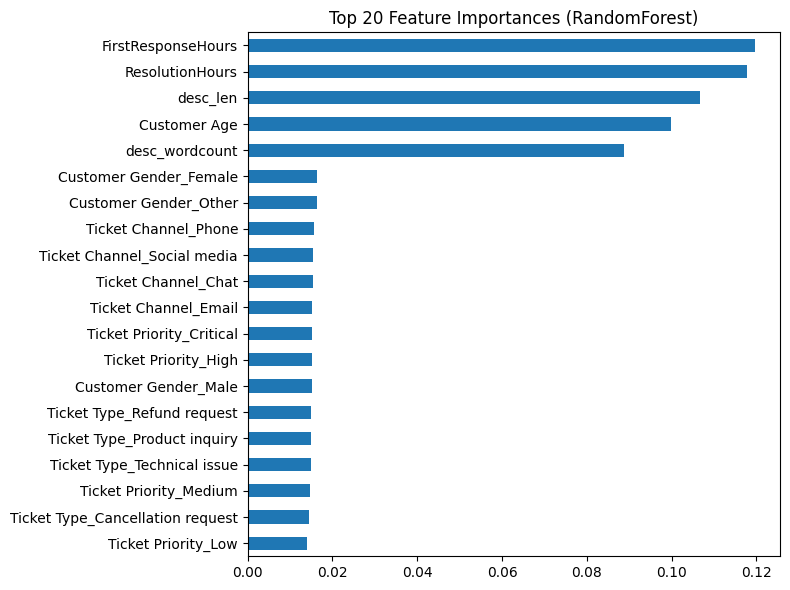

In [62]:
ohe = clf.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(cat_features)
feature_names = num_features + list(cat_names)

importances = clf.named_steps['model'].feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
fi.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances (RandomForest)')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=200)
plt.show()


In [65]:
lr_pipe = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])
lr_pipe.fit(X_train, y_train)
y_pred_lr = lr_pipe.predict(X_test)
print("Logistic Acc:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Logistic Acc: 0.6119133574007221
              precision    recall  f1-score   support

           0       0.62      0.94      0.75       337
           1       0.52      0.11      0.18       217

    accuracy                           0.61       554
   macro avg       0.57      0.52      0.46       554
weighted avg       0.58      0.61      0.52       554



In [70]:
res = X_test.copy()
res['Actual_Satisfied'] = y_test.values
res['Predicted_Satisfied'] = y_pred
orig = df_model.loc[res.index, ['Customer Satisfaction Rating','Ticket Subject','Ticket Description']]
display_df = pd.concat([res.reset_index(drop=True), orig.reset_index(drop=True)], axis=1)
display_df.head(10).to_csv('sample_predictions.csv', index=False)
display(display_df.head(10))


,Customer Age,FirstResponseHours,ResolutionHours,desc_len,desc_wordcount,Customer Gender,Product Purchased,Ticket Type,Ticket Priority,Ticket Channel,Actual_Satisfied,Predicted_Satisfied,Customer Satisfaction Rating,Ticket Subject,Ticket Description
0,70,23.492500,7.459167,167,26,Male,Nest Thermostat,Product inquiry,Low,Email,1,0,5.0,Delivery problem,I'm having an issue with the {product_purchase...
1,58,0.515000,11.815000,304,39,Male,Samsung Soundbar,Technical issue,High,Social media,0,0,3.0,Delivery problem,I'm having an issue with the {product_purchase...
2,68,7.247778,1.697778,317,54,Female,MacBook Pro,Technical issue,Critical,Chat,1,0,5.0,Network problem,I'm having an issue with the {product_purchase...
3,49,2.108056,7.224722,272,41,Other,Nintendo Switch Pro Controller,Cancellation request,Medium,Chat,1,0,4.0,Peripheral compatibility,I'm having an issue with the {product_purchase...
4,48,12.202500,0.052500,320,52,Female,Canon DSLR Camera,Cancellation request,Low,Phone,1,1,5.0,Installation support,"I've recently set up my {product_purchased}, b..."
5,41,16.272500,3.339167,276,47,Female,Xbox,Refund request,Critical,Phone,1,0,4.0,Data loss,I'm having an issue with the {product_purchase...
6,45,16.897778,8.214444,204,29,Male,Nest Thermostat,Billing inquiry,Critical,Phone,0,0,1.0,Account access,I'm having an issue with the {product_purchase...
7,35,12.345556,1.695556,307,52,Female,Fitbit Charge,Product inquiry,High,Phone,0,0,2.0,Product setup,I'm having an issue with the {product_purchase...
8,49,16.495278,23.228611,280,47,Female,LG OLED,Technical issue,High,Chat,0,0,1.0,Refund request,I'm having an issue with the {product_purchase...
9,20,1.572500,1.972500,287,57,Female,Bose SoundLink Speaker,Refund request,Medium,Email,0,0,2.0,Refund request,I'm having an issue with the {product_purchase...


In [73]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5956678700361011

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.89      0.73       337
           1       0.45      0.13      0.21       217

    accuracy                           0.60       554
   macro avg       0.53      0.51      0.47       554
weighted avg       0.55      0.60      0.52       554



In [75]:
import pandas as pd

results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
results.to_csv("sample_predictions.csv", index=False)

print(results.head(10))


      Actual  Predicted
910        1          0
2440       0          0
2192       1          0
251        1          0
1480       1          1
2583       1          0
1841       0          0
2672       0          0
1532       0          0
2266       0          0


In [76]:
df.isnull().sum()


Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64

In [82]:
df['Resolution'] = df['Resolution'].fillna('Not Provided')
df['Time to Resolution'] = df['Time to Resolution'].fillna('Unknown')
df['Customer Satisfaction Rating'] = df['Customer Satisfaction Rating'].fillna(df['Customer Satisfaction Rating'].mean())

df['First Response Time'] = df['First Response Time'].fillna('Unknown')


In [83]:
df.isnull().sum()


Ticket ID                       0
Customer Name                   0
Customer Email                  0
Customer Age                    0
Customer Gender                 0
Product Purchased               0
Date of Purchase                0
Ticket Type                     0
Ticket Subject                  0
Ticket Description              0
Ticket Status                   0
Resolution                      0
Ticket Priority                 0
Ticket Channel                  0
First Response Time             0
Time to Resolution              0
Customer Satisfaction Rating    0
dtype: int64